### Please keep in mind this is an initial, naive solution and is subject to drastic change.

In [17]:
from pathlib import Path
from anomalib.data.utils import read_image
from anomalib.deploy import TorchInferencer
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from anomalib.data.folder import Folder
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

### Additionally I modified the data in the following ways:
- I moved all the normal and abnomral instances into their own directories all together,
- I also removed any images with \*ref|Ref\* in their name that were in the abnormal/anomalous directories from being since they are from the refrence image, meaning they are what the client wants. You can verify this for yourselfes.
- To start you might also want to remove the images that are masked initially if you are only running this file, expect updates soon...

In [18]:
from anomalib.data.task_type import TaskType

cwd = Path.cwd()
parent_dir = cwd.parent

data_module = Folder(
    root=parent_dir / "Hackathon/Reels",
    normal_dir="normal",
    abnormal_dir="abnormal",
    normal_split_ratio=0.1,
    image_size=(166, 166),
    train_batch_size=16,
    eval_batch_size=16,
    task=TaskType.CLASSIFICATION,
    normalization="imagenet",
    seed=44,
)
data_module.setup()
data_module.prepare_data()
i, data = next(enumerate(data_module.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image'])


In [19]:
print(data["image"].shape)

torch.Size([16, 3, 166, 166])


In [20]:
from anomalib.models import Padim

model = Padim(
    input_size=(256, 256),
    backbone="resnet18",
    layers=["layer1", "layer2", "layer3"],
)

FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor will be removed in a future release.


In [21]:
from anomalib.post_processing import NormalizationMethod, ThresholdMethod
from anomalib.utils.callbacks import (
    MetricsConfigurationCallback,
    MinMaxNormalizationCallback,
    PostProcessingConfigurationCallback,
)
from anomalib.utils.callbacks.export import ExportCallback, ExportMode

callbacks = [
    MetricsConfigurationCallback(
        task=TaskType.CLASSIFICATION,
        image_metrics=["AUROC", "RECALL"],
    ),
    ModelCheckpoint(
        every_n_epochs=4,
        monitor="image_AUROC",
    ),
    PostProcessingConfigurationCallback(
        normalization_method=NormalizationMethod.MIN_MAX,
        threshold_method=ThresholdMethod.ADAPTIVE,
    ),
    MinMaxNormalizationCallback(),
    ExportCallback(
        input_size=(166, 166),
        dirpath=str(Path.cwd()),
        filename="model",
        export_mode=ExportMode.TORCH,
    ),
]

In [22]:
trainer = Trainer(
    callbacks=callbacks,
    accelerator="auto",
    auto_scale_batch_size=False,
    check_val_every_n_epoch=4,
    devices=1,
    gpus=None,
    max_epochs=20,
    num_sanity_val_steps=0,
    val_check_interval=1.0,
)
trainer.fit(model=model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | PadimModel               | 2.8 M 
3 | image_metrics         | AnomalibMetricCollection | 0     
4 | pixel_metrics         | AnomalibMetricCollection | 0     
5 | normalization_metrics | MinMax                   | 0     
-------------------------------------------------------------------
2.8 M     Trainable params
0         Non-trainable params
2.8 M     Total params
11.131    Total estimated model params size (MB)


Epoch 19: 100%|██████████| 23/23 [00:25<00:00,  1.10s/it, loss=nan, v_num=10, image_AUROC=0.616]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 23/23 [00:25<00:00,  1.11s/it, loss=nan, v_num=10, image_AUROC=0.616]


In [23]:
test_results = trainer.test(model=model, datamodule=data_module)

You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

Testing DataLoader 0: 100%|██████████| 6/6 [00:04<00:00,  1.43it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7064590454101562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


(166, 166, 3)

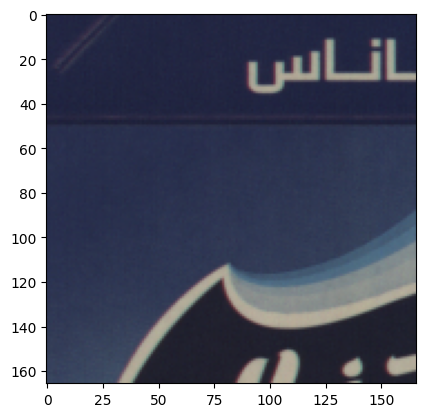

In [24]:
from matplotlib import pyplot as plt
norm_imagepath = parent_dir / "Hackathon/Reels/normal/NRefSpot30.bmp"
norm_image = read_image(norm_imagepath)
plt.imshow(norm_image)
norm_image.shape

In [25]:
import numpy as np

def split_into_patches(image, patch_size=166) -> np.ndarray:
    """
    Splits an image into non-overlapping patches of size (patch_size, patch_size).
    Pads the image with zeros if needed.

    Parameters:
    - image (ndarray): The image to be split. Shape (H, W, C)
    - patch_size (int): The size of each square patch

    Returns:
    - patches (ndarray): The patches. Shape (N, patch_size, patch_size, C)
    """
    # Image dimensions
    H, W, C = image.shape
    
    # Calculate required padding
    pad_H = (patch_size - H % patch_size) % patch_size
    pad_W = (patch_size - W % patch_size) % patch_size
    
    # Pad the image with zeros
    padded_image = np.pad(image, ((0, pad_H), (0, pad_W), (0, 0)), 'constant')
    
    # Reshape into patches
    reshaped_image = padded_image.reshape(
        padded_image.shape[0] // patch_size, patch_size,
        padded_image.shape[1] // patch_size, patch_size,
        C
    )
    
    # Transpose and reshape to finalize the patches
    patches = reshaped_image.transpose(0, 2, 1, 3, 4).reshape(-1, patch_size, patch_size, C)
    
    return patches
# abnormal_job_image = split_into_patches(abnormal_image)
# Example usage
# image_shape = (2482, 7062, 3)
# example_image = np.random.rand(*image_shape).astype(np.float32)

# patches = split_into_patches(example_image)

# print(patches.shape)
# print(280*256*256)
# print(2482*7062)


# abnormal_job_image.shape

In [26]:
from torchvision import transforms
import torch

def normalize_patches(patches):
    """
    Normalize image patches using ImageNet norms.

    Parameters:
    - patches (ndarray): The image patches. Shape (N, H, W, C)

    Returns:
    - normalized_patches (ndarray): The normalized patches. Shape (N, H, W, C)
    """
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # Convert to PyTorch tensor and change to (N, C, H, W)
    #? RM'd float conversion
    # torch_tensor = torch.from_numpy(patches)
    patches_tensor = torch.from_numpy(patches).permute(0, 3, 1, 2).float()

    # Apply normalization
    normalized_patches_tensor = normalize(patches_tensor)

    # Convert back to numpy and change to (N, H, W, C)
    normalized_patches = normalized_patches_tensor.permute(0, 2, 3, 1).cpu().numpy()

    return np.asarray(normalized_patches, dtype=np.uint8)

# Simulate read_image and split_into_patches function
# abnormal_job_image_patched = np.random.rand(100, 256, 256, 3).astype(np.float32)

# Apply normalization
# normalized_patches = normalize_patches(abnormal_job_image_patched)

# normalized_patches.shape, np.min(normalized_patches), np.max(normalized_patches)


### Loading the saved model

In [27]:
# import torch
# model = model.load_from_checkpoint(Path.cwd() / 'lightning_logs/version_6/checkpoints/epoch=3-step=36.ckpt')
# model.laod_sta
model_path = Path.cwd() / 'weights/torch/model.pt'
inferencer = TorchInferencer(path=model_path)

In [28]:
#! Predict -> returns ImageResult type
norm_predictions = inferencer.predict(image=norm_image)
# type(predictions)
# predictions
# predictions2 = inferencer.predict(norm_image=abnormal_image)

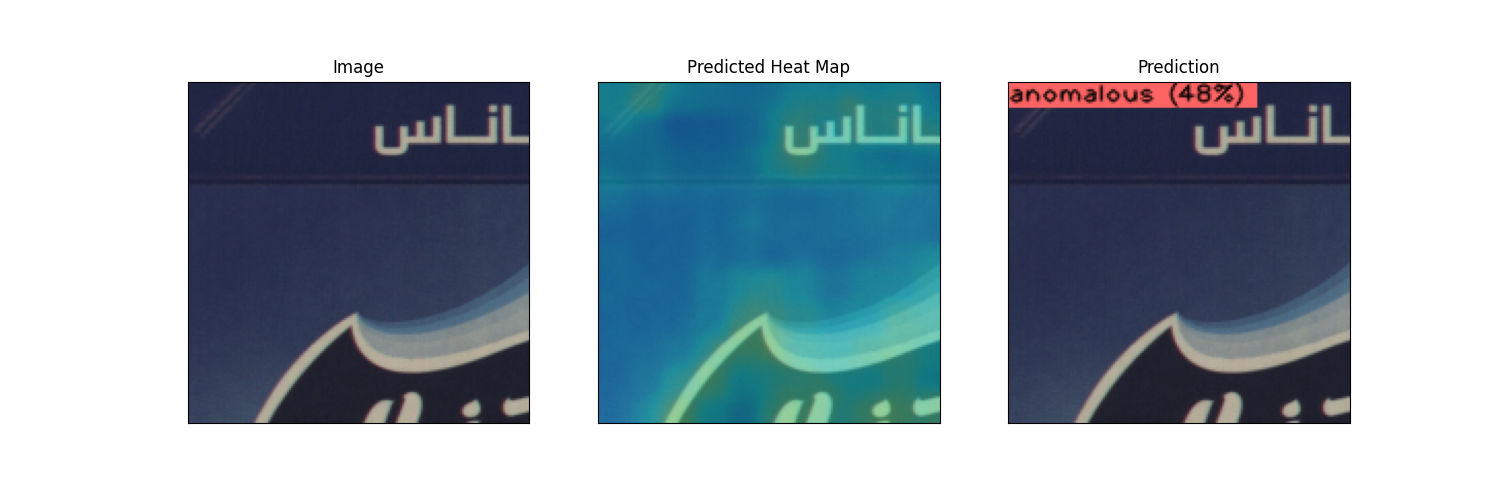

In [29]:
from anomalib.post_processing import Visualizer, VisualizationMode
from PIL import Image

visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
output_image = visualizer.visualize_image(norm_predictions)
Image.fromarray(output_image)
# output_image.shape

In [30]:
# import anomalib.data.utils.transform as tf

# visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
# pred_abnormal = inferencer.predict(image=abnormal_image)
abnormal_job_path = parent_dir / 'Hackathon/Reels/Job1.bmp'
# print(abnormal_job_path)
abnormal_job_image_patchnormed = read_image(abnormal_job_path)
# print(type(abnormal_job_image_patchnormed))
abnormal_job_image_patchnormed = split_into_patches(abnormal_job_image_patchnormed)
# abnormal_job_image_patchnormed = normalize_patches(abnormal_job_image_patchnormed)


In [31]:
# print(type(normd_abnormal_job_image_patched[0]))
print(type(abnormal_job_image_patchnormed))
# h = read_image(normd_abnormal_job_image_patched)
# visualizer.visualize_image(normd_abnormal_job_image_patched)
# print(h.shape)
# (normd_abnormal_job_image_patched)
preds_full_print_job = []
for i in range(len(abnormal_job_image_patchnormed)):
    # abnormal_job_image_patchnormed[i] = normalize_patches(abnormal_job_image_patchnormed[i])
    preds_full_print_job.append(inferencer.predict(image=abnormal_job_image_patchnormed[i]))
    break
    # Image.fromarray(visualizer.visualize_image(preds_full_print_job[i])).save(f"./lightning_logs/tmp_imgs/Job1_Path{i}.png")
    # Image.fromarray(visualizer.visualize_image(predsJob))
    # h = read_image(abnormal_job_image_patchnormed)

    # break
    # out_im_batch_job = visualizer.visualize_image(h)
    # if i ==40:
    #     break
# output_image = visualizer.visualize_image(normd_abnormal_job_image_patched[180])
# Image.fromarray(output_image)
# type(abnormal_job_image_patchnormed)


<class 'numpy.ndarray'>


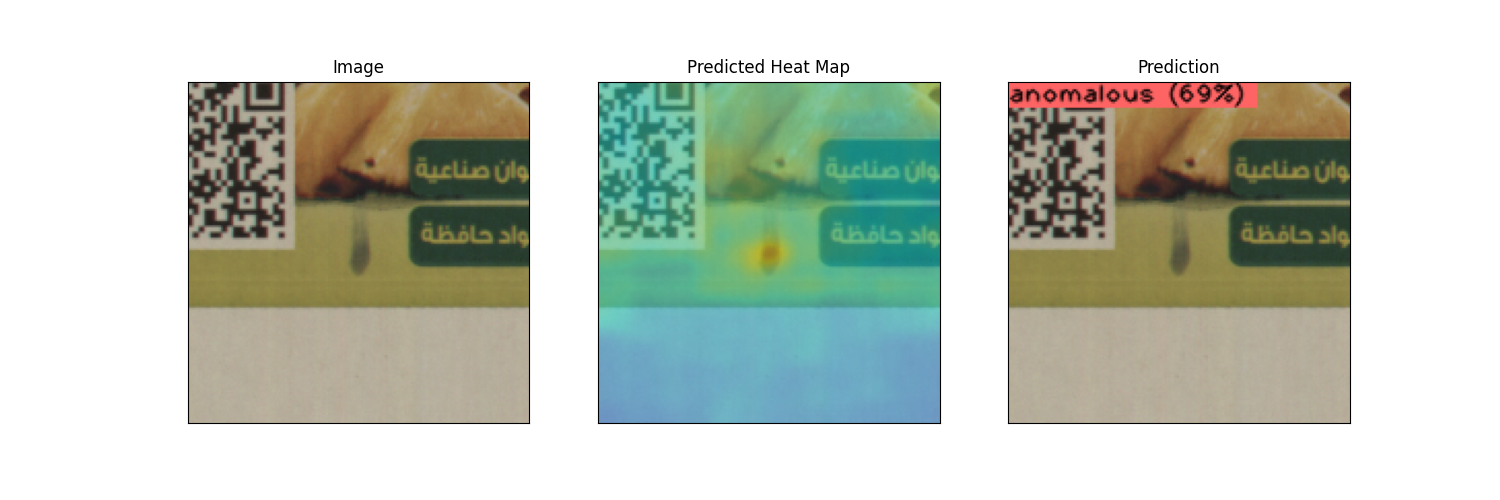

In [32]:
heldout_abnormal_imagepath = parent_dir / "Hackathon/Reels/holdout_anomalous_test/YSpot34.bmp"
visualizer = Visualizer(mode=VisualizationMode.FULL, task=TaskType.CLASSIFICATION)
test_pred= inferencer.predict(image=heldout_abnormal_imagepath)
Image.fromarray(visualizer.visualize_image(test_pred))